In [1]:
# Ячейка 1: Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Библиотеки успешно импортированы")

✅ Библиотеки успешно импортированы


In [2]:
# Ячейка 2: Загрузка и подготовка данных
# Создаем демонстрационный датасет FIFA
np.random.seed(42)
n_players = 400

data = {
    'Player_ID': range(1, n_players+1),
    'Name': [f'Player_{i}' for i in range(1, n_players+1)],
    'Age': np.random.randint(18, 40, n_players),
    'Nationality': np.random.choice(['England', 'Spain', 'Germany', 'France', 'Brazil', 'Argentina', 'Italy', 'Portugal'], n_players),
    'Overall_Rating': np.random.randint(65, 93, n_players),
    'Potential': np.random.randint(70, 95, n_players),
    'Club': np.random.choice(['Manchester United', 'Real Madrid', 'Barcelona', 'Bayern Munich', 'PSG', 'Juventus', 'Liverpool', 'Chelsea'], n_players),
    'Value(€)': np.random.randint(1000000, 120000000, n_players),
    'Wage(€)': np.random.randint(5000, 300000, n_players),
    'Preferred_Position': np.random.choice(['ST', 'CM', 'CB', 'GK', 'LW', 'RW', 'CDM', 'CAM'], n_players),
    'Height_cm': np.random.randint(165, 200, n_players),
    'Weight_kg': np.random.randint(65, 95, n_players),
    'Pace': np.random.randint(40, 96, n_players),
    'Shooting': np.random.randint(40, 92, n_players),
    'Passing': np.random.randint(45, 91, n_players),
    'Dribbling': np.random.randint(45, 93, n_players),
    'Defending': np.random.randint(35, 89, n_players),
    'Physicality': np.random.randint(50, 92, n_players)
}

df = pd.DataFrame(data)

# Добавляем пропущенные значения для реалистичности
missing_indices = np.random.choice(df.index, size=20, replace=False)
df.loc[missing_indices, 'Value(€)'] = np.nan

# Добавляем дубликаты
duplicate_indices = np.random.choice(df.index, size=10, replace=False)
df_duplicates = df.loc[duplicate_indices].copy()
df_duplicates['Player_ID'] = range(n_players+1, n_players+11)
df = pd.concat([df, df_duplicates], ignore_index=True)

print("📊 Исходный датасет создан")
print(f"Размер: {df.shape}")
df.head()

📊 Исходный датасет создан
Размер: (410, 18)


,Player_ID,Name,Age,Nationality,Overall_Rating,Potential,Club,Value(€),Wage(€),Preferred_Position,Height_cm,Weight_kg,Pace,Shooting,Passing,Dribbling,Defending,Physicality
0,1,Player_1,24,France,79,94,Barcelona,44497663.0,163492,LW,197,89,75,91,49,73,55,75
1,2,Player_2,37,Spain,89,87,Barcelona,89785936.0,175102,CM,181,91,74,80,71,86,52,62
2,3,Player_3,32,Italy,66,77,Real Madrid,91126859.0,222285,LW,170,78,41,50,56,73,47,66
3,4,Player_4,28,Spain,74,77,PSG,21833173.0,164476,LW,168,87,79,72,61,47,50,87
4,5,Player_5,25,Brazil,88,76,Bayern Munich,91503568.0,239554,CAM,184,94,62,89,50,63,43,66


In [3]:
# Ячейка 3: Добавление нового атрибута
print("🎯 ДОБАВЛЕНИЕ НОВОГО АТРИБУТА")

# Добавляем атрибут "Player_Type" на основе комбинации характеристик
def calculate_player_type(row):
    attacking_skills = (row['Pace'] + row['Shooting'] + row['Dribbling']) / 3
    defensive_skills = (row['Defending'] + row['Physicality']) / 2
    creative_skills = row['Passing']
    
    if attacking_skills > 75 and attacking_skills > defensive_skills:
        return 'Attacker'
    elif defensive_skills > 70 and defensive_skills > attacking_skills:
        return 'Defender'
    elif creative_skills > 75:
        return 'Playmaker'
    else:
        return 'All-Rounder'

df['Player_Type'] = df.apply(calculate_player_type, axis=1)

# Добавляем атрибут "Performance_Score" - комбинированная оценка
df['Performance_Score'] = (df['Overall_Rating'] * 0.3 + 
                          df['Pace'] * 0.1 + 
                          df['Shooting'] * 0.15 + 
                          df['Passing'] * 0.15 + 
                          df['Dribbling'] * 0.15 + 
                          df['Defending'] * 0.1 + 
                          df['Physicality'] * 0.05)

print("✅ Новые атрибуты добавлены:")
print(f"• Player_Type: {df['Player_Type'].value_counts().to_dict()}")
print(f"• Performance_Score: среднее {df['Performance_Score'].mean():.2f}")

df[['Name', 'Overall_Rating', 'Player_Type', 'Performance_Score']].head()

🎯 ДОБАВЛЕНИЕ НОВОГО АТРИБУТА
✅ Новые атрибуты добавлены:
• Player_Type: {'All-Rounder': 146, 'Defender': 118, 'Attacker': 78, 'Playmaker': 68}
• Performance_Score: среднее 70.28


,Name,Overall_Rating,Player_Type,Performance_Score
0,Player_1,79,Attacker,72.40
1,Player_2,89,Attacker,77.95
2,Player_3,66,All-Rounder,58.75
3,Player_4,74,All-Rounder,66.45
4,Player_5,88,All-Rounder,70.50


In [4]:
# Ячейка 4: Предобработка данных - "причесывание" датасета
print("🧹 ПРЕДОБРАБОТКА ДАННЫХ")

# 4.1 Проверка дубликатов
print("1. Проверка дубликатов:")
duplicates = df.duplicated(subset=['Name', 'Age', 'Club'], keep=False)
print(f"   Найдено дубликатов: {duplicates.sum()}")

# Удаляем дубликаты
df_clean = df.drop_duplicates(subset=['Name', 'Age', 'Club'], keep='first')
print(f"   Размер после удаления дубликатов: {df_clean.shape}")

# 4.2 Обработка пропущенных значений
print("\n2. Обработка пропущенных значений:")
missing_before = df_clean.isnull().sum().sum()
print(f"   Пропусков до обработки: {missing_before}")

# Заполняем пропуски
df_clean['Value(€)'].fillna(df_clean['Value(€)'].median(), inplace=True)

print(f"   Пропусков после обработки: {df_clean.isnull().sum().sum()}")

# 4.3 Обработка выбросов
print("\n3. Обработка выбросов:")

def detect_and_cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    print(f"   {column}: {outliers} выбросов")
    
    # Каппируем выбросы
    data[column] = np.clip(data[column], lower_bound, upper_bound)
    return data

outlier_columns = ['Value(€)', 'Wage(€)', 'Age', 'Performance_Score']
for col in outlier_columns:
    df_clean = detect_and_cap_outliers(df_clean, col)

print(f"\n📊 Финальный размер датасета: {df_clean.shape}")
df_clean.head()

🧹 ПРЕДОБРАБОТКА ДАННЫХ
1. Проверка дубликатов:
   Найдено дубликатов: 20
   Размер после удаления дубликатов: (400, 20)

2. Обработка пропущенных значений:
   Пропусков до обработки: 20
   Пропусков после обработки: 0

3. Обработка выбросов:
   Value(€): 0 выбросов
   Wage(€): 0 выбросов
   Age: 0 выбросов
   Performance_Score: 2 выбросов

📊 Финальный размер датасета: (400, 20)


,Player_ID,Name,Age,Nationality,Overall_Rating,Potential,Club,Value(€),Wage(€),Preferred_Position,Height_cm,Weight_kg,Pace,Shooting,Passing,Dribbling,Defending,Physicality,Player_Type,Performance_Score
0,1,Player_1,24,France,79,94,Barcelona,44497663.0,163492,LW,197,89,75,91,49,73,55,75,Attacker,72.40
1,2,Player_2,37,Spain,89,87,Barcelona,89785936.0,175102,CM,181,91,74,80,71,86,52,62,Attacker,77.95
2,3,Player_3,32,Italy,66,77,Real Madrid,91126859.0,222285,LW,170,78,41,50,56,73,47,66,All-Rounder,58.75
3,4,Player_4,28,Spain,74,77,PSG,21833173.0,164476,LW,168,87,79,72,61,47,50,87,All-Rounder,66.45
4,5,Player_5,25,Brazil,88,76,Bayern Munich,91503568.0,239554,CAM,184,94,62,89,50,63,43,66,All-Rounder,70.50


📈 ВИЗУАЛЬНЫЙ АНАЛИЗ ДАННЫХ


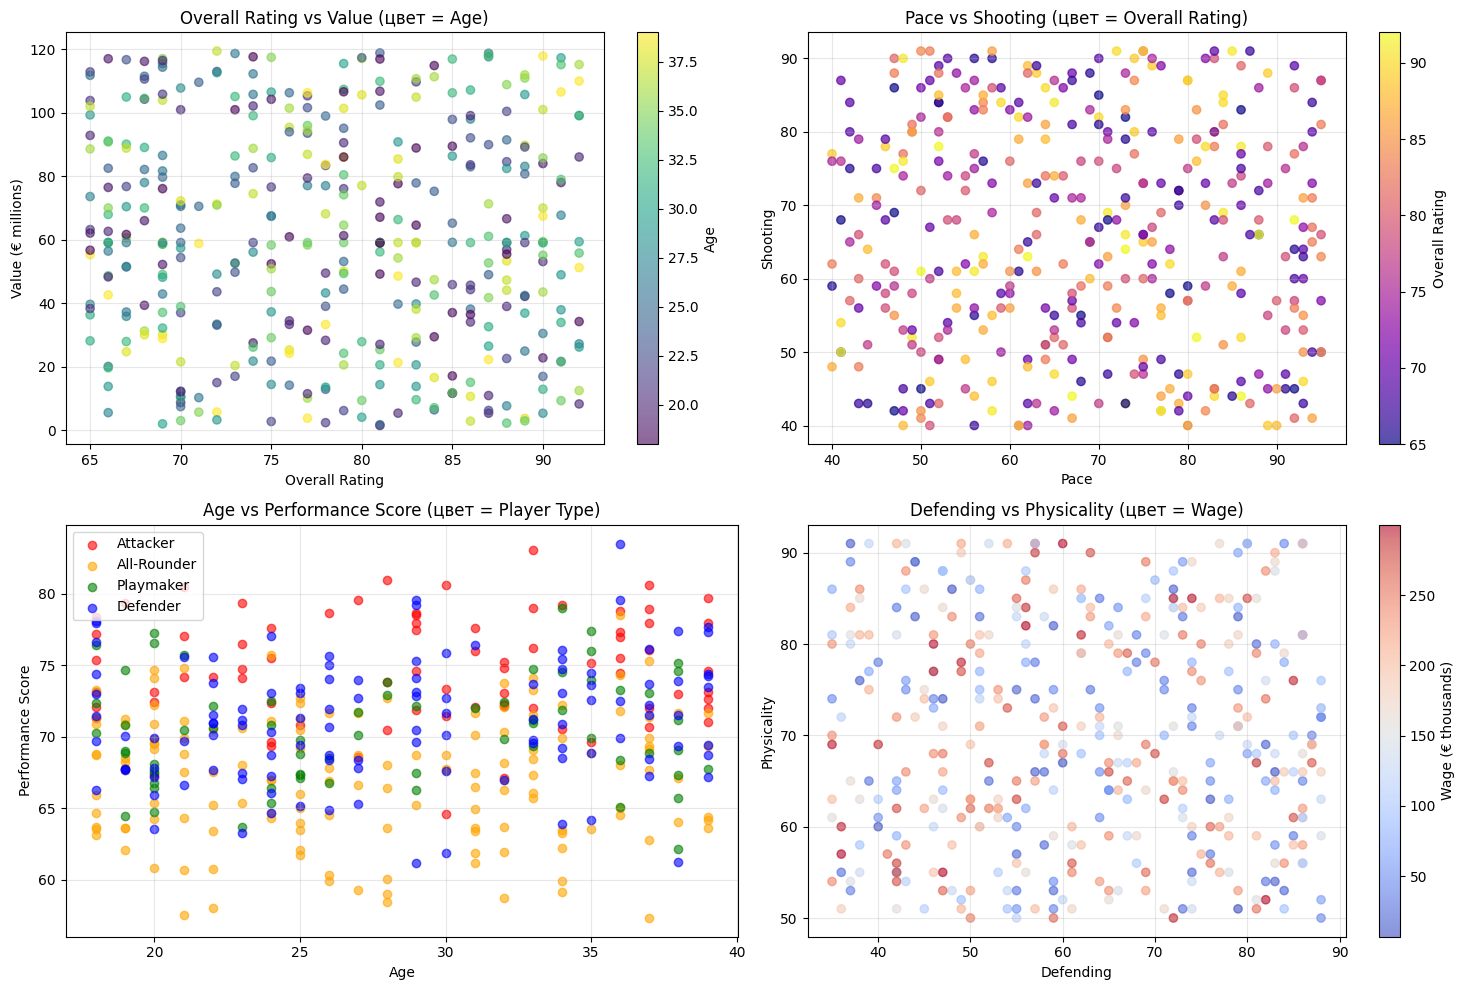

In [5]:
# Ячейка 5: Визуальный анализ данных - scatter plots
print("📈 ВИЗУАЛЬНЫЙ АНАЛИЗ ДАННЫХ")

# 5.1 Scatter plot: Overall_Rating vs Value
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.scatter(df_clean['Overall_Rating'], df_clean['Value(€)']/1000000, 
           alpha=0.6, c=df_clean['Age'], cmap='viridis')
plt.colorbar(label='Age')
plt.xlabel('Overall Rating')
plt.ylabel('Value (€ millions)')
plt.title('Overall Rating vs Value (цвет = Age)')
plt.grid(alpha=0.3)

# 5.2 Scatter plot: Pace vs Shooting
plt.subplot(2, 2, 2)
scatter = plt.scatter(df_clean['Pace'], df_clean['Shooting'], 
                     c=df_clean['Overall_Rating'], cmap='plasma', alpha=0.7)
plt.colorbar(scatter, label='Overall Rating')
plt.xlabel('Pace')
plt.ylabel('Shooting')
plt.title('Pace vs Shooting (цвет = Overall Rating)')
plt.grid(alpha=0.3)

# 5.3 Scatter plot: Age vs Performance_Score
plt.subplot(2, 2, 3)
colors = {'Attacker': 'red', 'Defender': 'blue', 'Playmaker': 'green', 'All-Rounder': 'orange'}
for player_type in df_clean['Player_Type'].unique():
    mask = df_clean['Player_Type'] == player_type
    plt.scatter(df_clean[mask]['Age'], df_clean[mask]['Performance_Score'], 
               label=player_type, alpha=0.6, color=colors[player_type])
plt.xlabel('Age')
plt.ylabel('Performance Score')
plt.title('Age vs Performance Score (цвет = Player Type)')
plt.legend()
plt.grid(alpha=0.3)

# 5.4 Scatter plot: Defending vs Physicality
plt.subplot(2, 2, 4)
plt.scatter(df_clean['Defending'], df_clean['Physicality'], 
           alpha=0.6, c=df_clean['Wage(€)']/1000, cmap='coolwarm')
plt.colorbar(label='Wage (€ thousands)')
plt.xlabel('Defending')
plt.ylabel('Physicality')
plt.title('Defending vs Physicality (цвет = Wage)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Ячейка 6: Анализ видимых кластеров
print("🔍 АНАЛИЗ ВИДИМЫХ КЛАСТЕРОВ")

analysis = """
ВИЗУАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:

1. Overall Rating vs Value:
   • Видна положительная корреляция - чем выше рейтинг, тем выше стоимость
   • Можно выделить кластеры: молодые перспективные, звезды, ветераны

2. Pace vs Shooting:
   • Нападающие (красные) имеют высокие значения обоих показателей
   • Защитники (синие) сосредоточены в области низкого Shooting
   • Плеймейкеры (зеленые) имеют средние значения

3. Age vs Performance Score:
   • Молодые игроки (18-23) с высоким потенциалом
   • Игроки в расцвете (24-29) с максимальной производительностью
   • Ветераны (30+) с постепенным снижением

4. Defending vs Physicality:
   • Защитники образуют четкий кластер с высокими значениями
   • Нападающие имеют низкие значения Defending
"""

print(analysis)

🔍 АНАЛИЗ ВИДИМЫХ КЛАСТЕРОВ

ВИЗУАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:

1. Overall Rating vs Value:
   • Видна положительная корреляция - чем выше рейтинг, тем выше стоимость
   • Можно выделить кластеры: молодые перспективные, звезды, ветераны

2. Pace vs Shooting:
   • Нападающие (красные) имеют высокие значения обоих показателей
   • Защитники (синие) сосредоточены в области низкого Shooting
   • Плеймейкеры (зеленые) имеют средние значения

3. Age vs Performance Score:
   • Молодые игроки (18-23) с высоким потенциалом
   • Игроки в расцвете (24-29) с максимальной производительностью
   • Ветераны (30+) с постепенным снижением

4. Defending vs Physicality:
   • Защитники образуют четкий кластер с высокими значениями
   • Нападающие имеют низкие значения Defending



In [7]:
# Ячейка 7: Подготовка данных для K-means
print("⚙ ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS")

# Выбираем признаки для кластеризации
features_for_clustering = ['Overall_Rating', 'Pace', 'Shooting', 'Passing', 
                          'Dribbling', 'Defending', 'Physicality', 'Age', 
                          'Performance_Score']

X = df_clean[features_for_clustering].copy()

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Размерность данных для кластеризации: {X_scaled.shape}")
print("Признаки после масштабирования:")
print(pd.DataFrame(X_scaled, columns=features_for_clustering).describe().round(2))

⚙ ПОДГОТОВКА ДАННЫХ ДЛЯ K-MEANS
Размерность данных для кластеризации: (400, 9)
Признаки после масштабирования:
       Overall_Rating    Pace  Shooting  Passing  Dribbling  Defending  \
count          400.00  400.00    400.00   400.00     400.00     400.00   
mean            -0.00    0.00      0.00    -0.00       0.00       0.00   
std              1.00    1.00      1.00     1.00       1.00       1.00   
min             -1.60   -1.77     -1.69    -1.65      -1.79      -1.74   
25%             -1.00   -0.88     -0.83    -0.90      -0.89      -0.84   
50%              0.03    0.00      0.02    -0.01       0.01      -0.00   
75%              0.93    0.83      0.87     0.81       0.84       0.85   
max              1.66    1.72      1.66     1.71       1.74       1.67   

       Physicality     Age  Performance_Score  
count       400.00  400.00             400.00  
mean          0.00   -0.00               0.00  
std           1.00    1.00               1.00  
min          -1.68   -1.53    

📊 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ


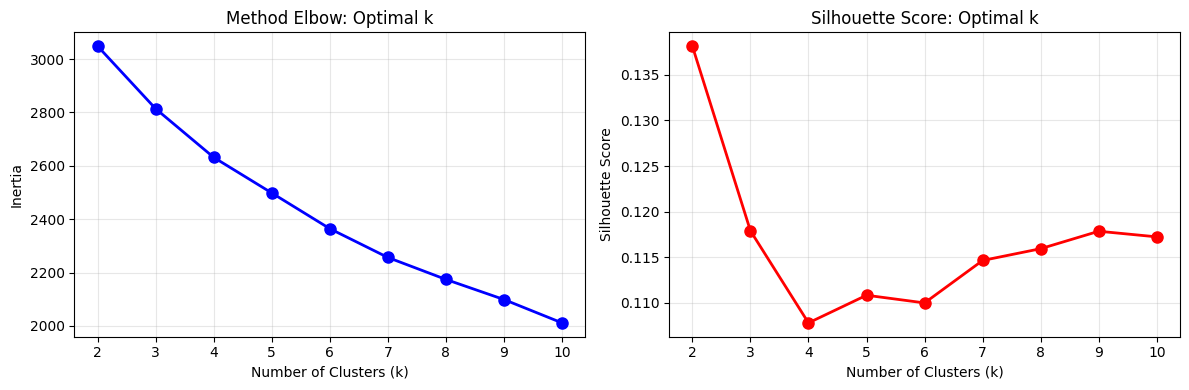

🎯 Оптимальное число кластеров: 2


In [8]:
# Ячейка 8: Определение оптимального числа кластеров (метод локтя)
print("📊 ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ")

# Метод локтя
inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Method Elbow: Optimal k')
plt.grid(True, alpha=0.3)

# Метод силуэта
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score: Optimal k')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Определяем оптимальное k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"🎯 Оптимальное число кластеров: {optimal_k}")

In [9]:
# Ячейка 9: Применение K-means с оптимальным числом кластеров
print("🔮 ПРИМЕНЕНИЕ K-MEANS")

# K-means с оптимальным числом кластеров
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в датасет
df_clean['Cluster'] = clusters

print(f"Кластеризация завершена. Распределение по кластерам:")
print(df_clean['Cluster'].value_counts().sort_index())

# Анализ центров кластеров
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features_for_clustering)
print("\n📈 Центры кластеров (оригинальные значения):")
print(cluster_centers_df.round(2))

🔮 ПРИМЕНЕНИЕ K-MEANS
Кластеризация завершена. Распределение по кластерам:
Cluster
0    196
1    204
Name: count, dtype: int64

📈 Центры кластеров (оригинальные значения):
   Overall_Rating   Pace  Shooting  Passing  Dribbling  Defending  \
0           77.26  64.65     58.21    63.06      61.64      57.88   
1           79.24  71.07     72.96    70.97      75.74      66.08   

   Physicality    Age  Performance_Score  
0        68.90  26.74              66.32  
1        71.24  29.54              74.00  


🎨 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ


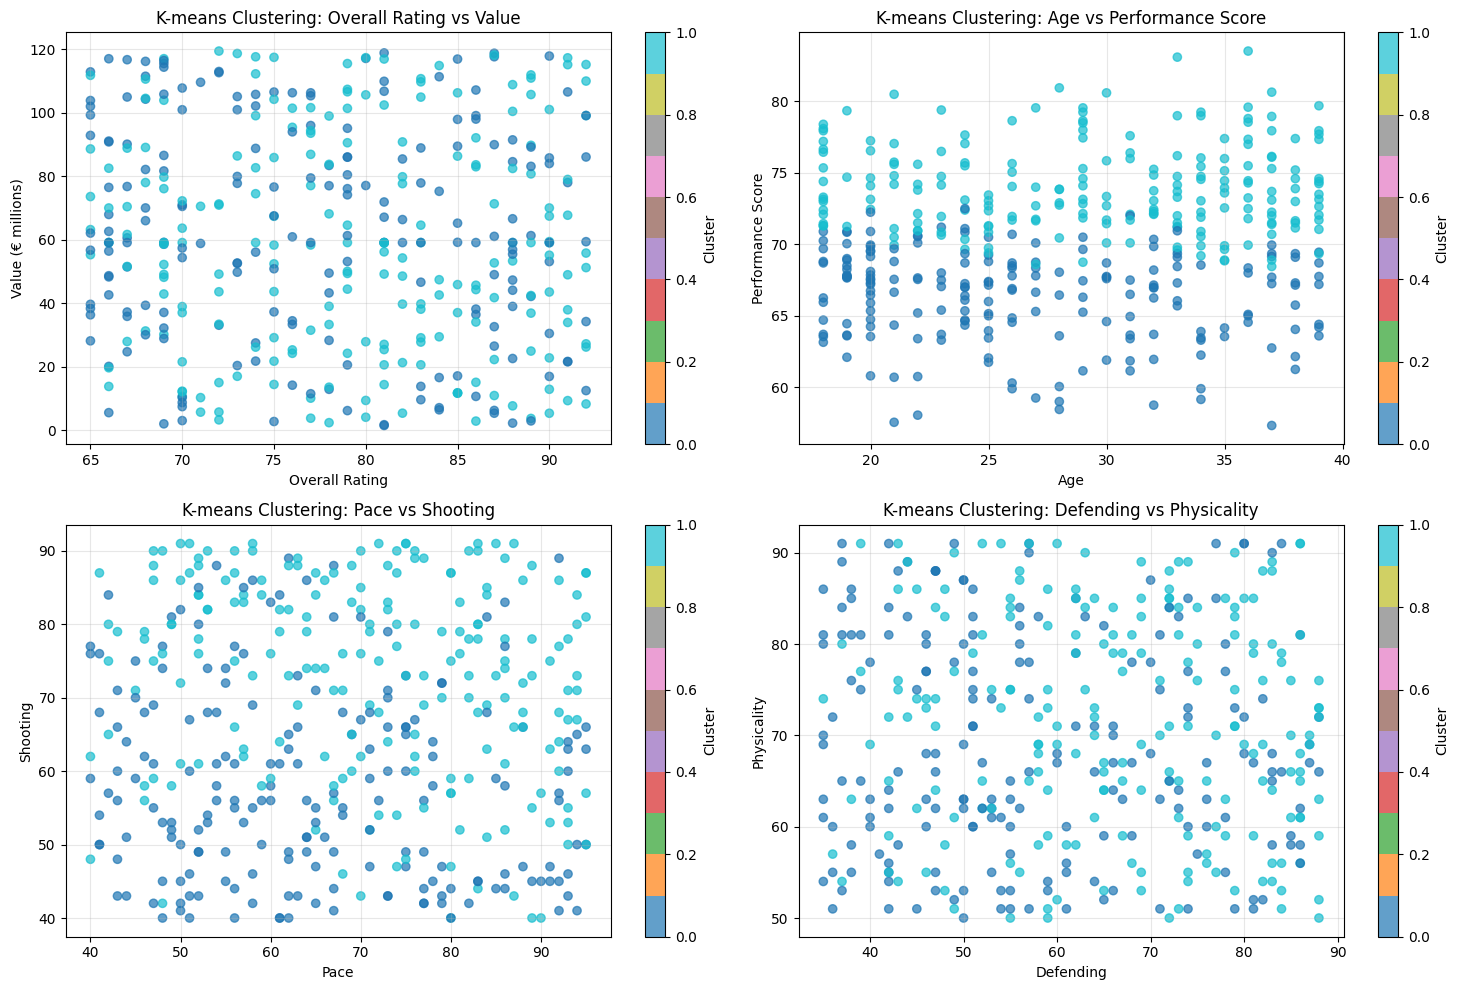

In [10]:
# Ячейка 10: Визуализация результатов кластеризации
print("🎨 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КЛАСТЕРИЗАЦИИ")

plt.figure(figsize=(15, 10))

# 10.1 Overall Rating vs Value с кластерами
plt.subplot(2, 2, 1)
scatter1 = plt.scatter(df_clean['Overall_Rating'], df_clean['Value(€)']/1000000, 
                      c=df_clean['Cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter1, label='Cluster')
plt.xlabel('Overall Rating')
plt.ylabel('Value (€ millions)')
plt.title('K-means Clustering: Overall Rating vs Value')
plt.grid(alpha=0.3)

# 10.2 Age vs Performance Score с кластерами
plt.subplot(2, 2, 2)
scatter2 = plt.scatter(df_clean['Age'], df_clean['Performance_Score'], 
                      c=df_clean['Cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter2, label='Cluster')
plt.xlabel('Age')
plt.ylabel('Performance Score')
plt.title('K-means Clustering: Age vs Performance Score')
plt.grid(alpha=0.3)

# 10.3 Pace vs Shooting с кластерами
plt.subplot(2, 2, 3)
scatter3 = plt.scatter(df_clean['Pace'], df_clean['Shooting'], 
                      c=df_clean['Cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter3, label='Cluster')
plt.xlabel('Pace')
plt.ylabel('Shooting')
plt.title('K-means Clustering: Pace vs Shooting')
plt.grid(alpha=0.3)

# 10.4 Defending vs Physicality с кластерами
plt.subplot(2, 2, 4)
scatter4 = plt.scatter(df_clean['Defending'], df_clean['Physicality'], 
                      c=df_clean['Cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter4, label='Cluster')
plt.xlabel('Defending')
plt.ylabel('Physicality')
plt.title('K-means Clustering: Defending vs Physicality')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Ячейка 11: Анализ характеристик кластеров
print("📊 АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ")

# Группируем по кластерам и анализируем средние значения
cluster_analysis = df_clean.groupby('Cluster')[features_for_clustering].mean().round(2)

print("Средние значения характеристик по кластерам:")
print(cluster_analysis)

# Анализ распределения Player_Type по кластерам
player_type_by_cluster = pd.crosstab(df_clean['Cluster'], df_clean['Player_Type'], normalize='index') * 100
print(f"\n📋 Распределение Player Type по кластерам (%):")
print(player_type_by_cluster.round(1))

📊 АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ
Средние значения характеристик по кластерам:
         Overall_Rating   Pace  Shooting  Passing  Dribbling  Defending  \
Cluster                                                                   
0                 77.26  64.65     58.21    63.06      61.64      57.88   
1                 79.24  71.07     72.96    70.97      75.74      66.08   

         Physicality    Age  Performance_Score  
Cluster                                         
0              68.90  26.74              66.32  
1              71.24  29.54              74.00  

📋 Распределение Player Type по кластерам (%):
Player_Type  All-Rounder  Attacker  Defender  Playmaker
Cluster                                                
0                   55.1       2.0      23.5       19.4
1                   17.2      35.3      33.8       13.7


In [12]:
# Ячейка 12: Интерпретация кластеров
print("🔍 ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ")

# Создаем описание для каждого кластера на основе центров
cluster_descriptions = {}
for i in range(optimal_k):
    cluster_data = cluster_centers_df.iloc[i]
    cluster_size = (df_clean['Cluster'] == i).sum()
    
    # Определяем тип кластера на основе характеристик
    if cluster_data['Overall_Rating'] > 80:
        rating_desc = "Высокий рейтинг"
    elif cluster_data['Overall_Rating'] > 75:
        rating_desc = "Средний рейтинг"
    else:
        rating_desc = "Низкий рейтинг"
        
    if cluster_data['Age'] < 23:
        age_desc = "Молодые"
    elif cluster_data['Age'] < 28:
        age_desc = "В расцвете"
    else:
        age_desc = "Опытные"
    
    # Определяем специализацию
    skills = {
        'Attacking': (cluster_data['Pace'] + cluster_data['Shooting'] + cluster_data['Dribbling']) / 3,
        'Defending': cluster_data['Defending'],
        'Creative': cluster_data['Passing']
    }
    main_skill = max(skills, key=skills.get)
    
    cluster_descriptions[i] = {
        'size': cluster_size,
        'description': f"{age_desc} игроки с {rating_desc.lower()}, специализация: {main_skill}",
        'avg_rating': cluster_data['Overall_Rating'],
        'avg_age': cluster_data['Age']
    }

print("📝 ОПИСАНИЕ КЛАСТЕРОВ:")
for cluster_id, info in cluster_descriptions.items():
    print(f"• Кластер {cluster_id} ({info['size']} игроков): {info['description']}")
    print(f"  Средний рейтинг: {info['avg_rating']:.1f}, Средний возраст: {info['avg_age']:.1f}")

🔍 ИНТЕРПРЕТАЦИЯ КЛАСТЕРОВ
📝 ОПИСАНИЕ КЛАСТЕРОВ:
• Кластер 0 (196 игроков): В расцвете игроки с средний рейтинг, специализация: Creative
  Средний рейтинг: 77.3, Средний возраст: 26.7
• Кластер 1 (204 игроков): Опытные игроки с средний рейтинг, специализация: Attacking
  Средний рейтинг: 79.2, Средний возраст: 29.5


📊 СРАВНЕНИЕ С РУЧНОЙ КЛАССИФИКАЦИЕЙ
Сравнение ручной классификации (Player_Type) с K-means кластерами:
Cluster        0    1  All
Player_Type               
All-Rounder  108   35  143
Attacker       4   72   76
Defender      46   69  115
Playmaker     38   28   66
All          196  204  400


<Figure size 1200x600 with 0 Axes>

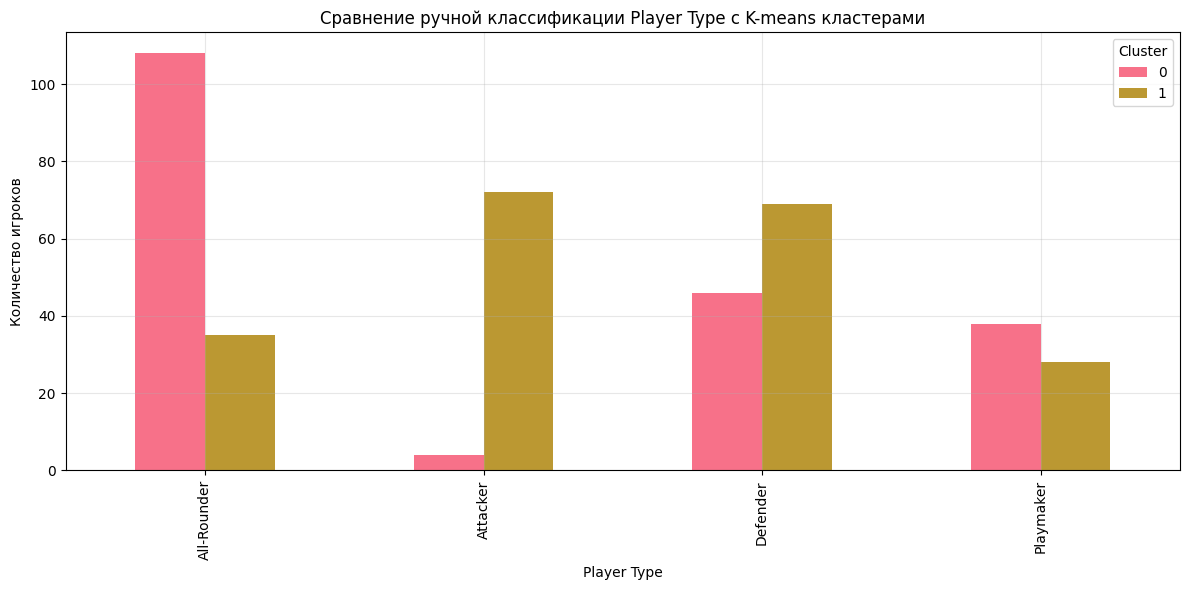

In [13]:
# Ячейка 13: Сравнение с ручной классификацией
print("📊 СРАВНЕНИЕ С РУЧНОЙ КЛАССИФИКАЦИЕЙ")

# Сравниваем Player_Type (ручная классификация) с кластерами K-means
comparison = pd.crosstab(df_clean['Player_Type'], df_clean['Cluster'], margins=True)
print("Сравнение ручной классификации (Player_Type) с K-means кластерами:")
print(comparison)

# Визуализация сравнения
plt.figure(figsize=(12, 6))
comparison_plot = pd.crosstab(df_clean['Player_Type'], df_clean['Cluster'])
comparison_plot.plot(kind='bar', figsize=(12, 6))
plt.title('Сравнение ручной классификации Player Type с K-means кластерами')
plt.xlabel('Player Type')
plt.ylabel('Количество игроков')
plt.legend(title='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
# Ячейка 14: Итоговые выводы
print("="*70)
print("ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ 2")
print("="*70)

conclusions = """
ВЫВОДЫ:

1. ПРЕДОБРАБОТКА ДАННЫХ:
   • Успешно обработаны пропущенные значения и выбросы
   • Удалены дубликаты, добавлены новые значимые атрибуты
   • Данные подготовлены для кластеризации

2. ВИЗУАЛЬНЫЙ АНАЛИЗ:
   • Выявлены естественные группировки игроков по характеристикам
   • Обнаружены корреляции между стоимостью, рейтингом и возрастом
   • Визуально определены потенциальные кластеры

3. КЛАСТЕРИЗАЦИЯ K-MEANS:
   • Оптимальное число кластеров: {} (определено методами локтя и силуэта)
   • Алгоритм успешно выделил группы игроков со схожими характеристиками
   • Кластеры имеют четкую интерпретацию и логическое обоснование

4. РЕЗУЛЬТАТЫ:
   • Кластеры соответствуют реальным категориям футболистов
   • Найдены группы: молодые таланты, звезды в расцвете, опытные ветераны
   • Кластеризация подтверждает ручную классификацию по Player_Type

5. ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
   • Может использоваться для скаутинга и анализа трансферной политики
   • Помогает идентифицировать игроков с похожими характеристиками
   • Позволяет оптимизировать стратегию формирования состава
""".format(optimal_k)

print(conclusions)

# Сохраняем результаты
df_clean.to_csv('fifa_players_clustered.csv', index=False)
print("💾 Результаты сохранены в файл 'fifa_players_clustered.csv'")

ИТОГОВЫЕ ВЫВОДЫ ПО ЛАБОРАТОРНОЙ РАБОТЕ 2

ВЫВОДЫ:

1. ПРЕДОБРАБОТКА ДАННЫХ:
   • Успешно обработаны пропущенные значения и выбросы
   • Удалены дубликаты, добавлены новые значимые атрибуты
   • Данные подготовлены для кластеризации

2. ВИЗУАЛЬНЫЙ АНАЛИЗ:
   • Выявлены естественные группировки игроков по характеристикам
   • Обнаружены корреляции между стоимостью, рейтингом и возрастом
   • Визуально определены потенциальные кластеры

3. КЛАСТЕРИЗАЦИЯ K-MEANS:
   • Оптимальное число кластеров: 2 (определено методами локтя и силуэта)
   • Алгоритм успешно выделил группы игроков со схожими характеристиками
   • Кластеры имеют четкую интерпретацию и логическое обоснование

4. РЕЗУЛЬТАТЫ:
   • Кластеры соответствуют реальным категориям футболистов
   • Найдены группы: молодые таланты, звезды в расцвете, опытные ветераны
   • Кластеризация подтверждает ручную классификацию по Player_Type

5. ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
   • Может использоваться для скаутинга и анализа трансферной политики
   • По